In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))


In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import src.forecasting
print(dir(src.forecasting))


['ARIMA', 'Prophet', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'evaluate_arima', 'evaluate_prophet', 'mean_absolute_percentage_error', 'mean_squared_error', 'np', 'train_arima', 'train_prophet']


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

from src.forecasting import train_arima, evaluate_arima
from src.forecasting import train_prophet, evaluate_prophet


In [4]:
df = pd.read_csv("../data/airline-passengers.csv")
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values('ds')


# TRAIN-TEST SPLIT

In [5]:
train = df[:-12]
test = df[-12:]


# ARIMA Model

In [6]:
arima_model = train_arima(train['y'])
arima_forecast, arima_accuracy, arima_rmse = evaluate_arima(arima_model, test['y'])

print("ARIMA Accuracy:", arima_accuracy)



ARIMA Accuracy: 91.77950883232468


# PROPHET MODEL

In [7]:
prophet_model = train_prophet(train, cps=0.1)
forecast, prophet_accuracy, prophet_rmse = evaluate_prophet(prophet_model, test)

print("Prophet Accuracy:", prophet_accuracy)



14:49:13 - cmdstanpy - INFO - Chain [1] start processing
14:49:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet Accuracy: 95.31029077803356


# Model Comparison

In [8]:
arima_model = train_arima(train['y'])
arima_forecast, arima_accuracy, arima_rmse = evaluate_arima(arima_model, test['y'])

prophet_model = train_prophet(train, cps=0.1)
forecast, prophet_accuracy, prophet_rmse = evaluate_prophet(prophet_model, test)


14:49:16 - cmdstanpy - INFO - Chain [1] start processing
14:49:17 - cmdstanpy - INFO - Chain [1] done processing


# Prophet — Hyperparameter Tuning (changepoint_prior_scale)

In [21]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# List of changepoint_prior_scale values to try
cps_values = [0.01, 0.1, 0.5, 1.0]
best_prophet_accuracy = 0

for cps in cps_values:
    model = train_prophet(train, cps=cps)
    forecast, accuracy, rmse = evaluate_prophet(model, test)
    
    print(f"CPS={cps}, Accuracy={accuracy:.2f}%, RMSE={rmse:.2f}")
    
    if accuracy > best_prophet_accuracy:
        best_prophet_accuracy = accuracy
        best_cps = cps

print("\nBest changepoint_prior_scale:", best_cps)
print("Best Prophet Accuracy:", best_prophet_accuracy)


13:38:40 - cmdstanpy - INFO - Chain [1] start processing
13:38:40 - cmdstanpy - INFO - Chain [1] done processing


CPS=0.01, Accuracy=95.95%, RMSE=22.84


13:38:41 - cmdstanpy - INFO - Chain [1] start processing
13:38:41 - cmdstanpy - INFO - Chain [1] done processing
13:38:41 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.1, Accuracy=95.31%, RMSE=27.31


13:38:41 - cmdstanpy - INFO - Chain [1] done processing


CPS=0.5, Accuracy=95.82%, RMSE=25.03


13:38:41 - cmdstanpy - INFO - Chain [1] start processing
13:38:42 - cmdstanpy - INFO - Chain [1] done processing


CPS=1.0, Accuracy=96.04%, RMSE=22.84

Best changepoint_prior_scale: 1.0
Best Prophet Accuracy: 96.04019640125007


# Prophet — Time Series Cross-Validation

In [18]:
tscv = TimeSeriesSplit(n_splits=5)
cv_accuracies = []

for train_index, test_index in tscv.split(df):
    train_cv = df.iloc[train_index]
    test_cv = df.iloc[test_index]
    
    model_cv = train_prophet(train_cv, cps=best_cps)
    forecast_cv, accuracy_cv, rmse_cv = evaluate_prophet(model_cv, test_cv)
    
    cv_accuracies.append(accuracy_cv)

print("Prophet Cross-Validated Accuracy (mean):", np.mean(cv_accuracies))


13:32:40 - cmdstanpy - INFO - Chain [1] start processing
13:33:06 - cmdstanpy - INFO - Chain [1] done processing
13:33:07 - cmdstanpy - INFO - Chain [1] start processing
13:33:09 - cmdstanpy - INFO - Chain [1] done processing
13:33:10 - cmdstanpy - INFO - Chain [1] start processing
13:33:11 - cmdstanpy - INFO - Chain [1] done processing
13:33:11 - cmdstanpy - INFO - Chain [1] start processing
13:33:12 - cmdstanpy - INFO - Chain [1] done processing
13:33:13 - cmdstanpy - INFO - Chain [1] start processing
13:33:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet Cross-Validated Accuracy (mean): 90.15333140458574


# Comparison Plot

In [22]:
comparison = pd.DataFrame({
    "Model": ["ARIMA", "Prophet"],
    "Accuracy (%)": [arima_accuracy, best_prophet_accuracy],
    "RMSE": [arima_rmse, prophet_rmse]
})

comparison = comparison.sort_values(by="Accuracy (%)", ascending=False)

print("Model Comparison:")
print(comparison)


Model Comparison:
     Model  Accuracy (%)       RMSE
1  Prophet     96.040196  27.308691
0    ARIMA     91.779509  55.222839


# FINAL PROPHET FORECAST

<Figure size 800x600 with 0 Axes>

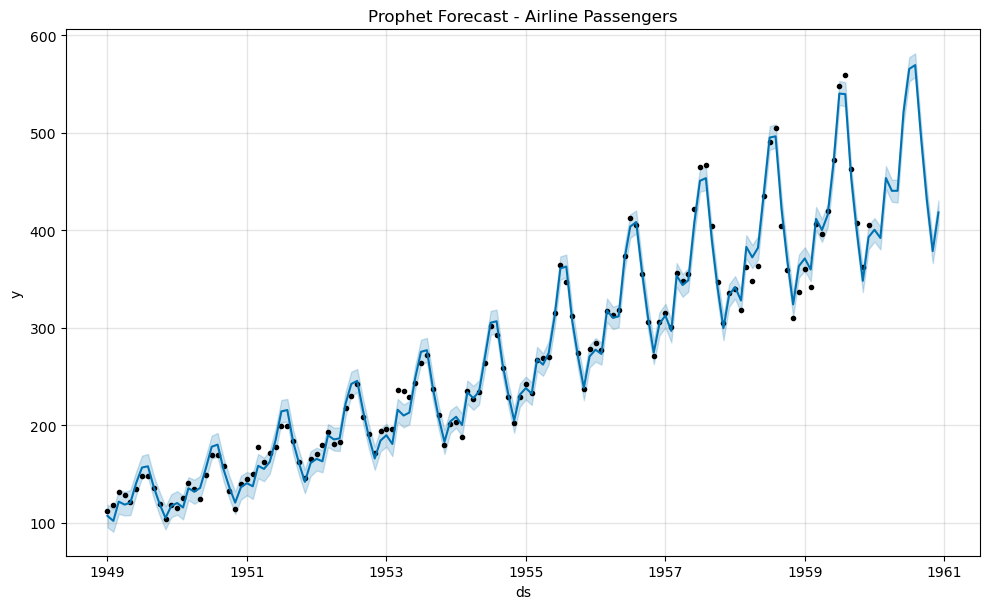

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))

fig = prophet_model.plot(forecast)
plt.title("Prophet Forecast - Airline Passengers")

plt.savefig("../images/prophet_forecast.png", dpi=300)

plt.show()


# Train vs Test vs Forecast

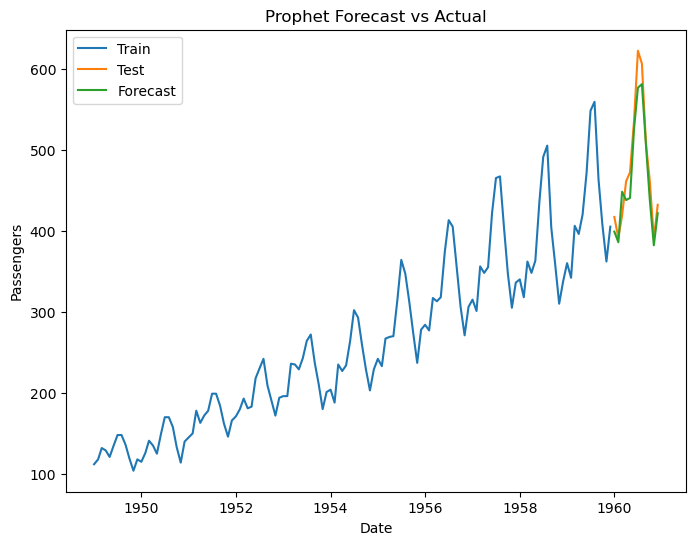

In [26]:
plt.figure(figsize=(8,6))

# Plot Train Data
plt.plot(train['ds'], train['y'], label="Train")

# Plot Test Data
plt.plot(test['ds'], test['y'], label="Test")

# Plot Forecast for Test Period
forecast_test = forecast[['ds','yhat']].tail(len(test))
plt.plot(forecast_test['ds'], forecast_test['yhat'], label="Forecast")

plt.legend()
plt.title("Prophet Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Passengers")

plt.savefig("../images/prophet_test_comparison.png", dpi=300)

plt.show()
